<a href="https://colab.research.google.com/github/Requiem5032/mcs-applied-ai/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [2]:
# import condacolab
# condacolab.check()

In [3]:
# !mamba install -q pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [4]:
# !mamba install -q numpy pandas matplotlib scikit-learn ipython ipykernel

# Setup GPU

In [5]:
import torch
torch.__version__

'2.5.1'

In [6]:
torch.cuda.is_available()

True

In [7]:
dev_index = torch.cuda.current_device()
device = torch.device(f'cuda:{dev_index}')

# Setup dataset

In [8]:
import torchvision
import torchvision.transforms as transforms

In [9]:
batch_size = 256
num_workers = 2

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))],
  )

In [11]:
train_ds = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

valid_ds = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

In [12]:
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

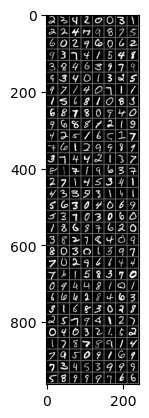

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(train_dl)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))

# Setup autoencoder

In [14]:
import torch.nn as nn

In [15]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, 4, 2 ,1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, 64*2, 4, 2 ,1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten(),
        nn.Linear((64*2) * 7*7, 7)
    )

  def forward(self, inp):
    return self.main(inp)

In [16]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.linear = nn.Linear(7, (64*2) * 7*7)
    self.main = nn.Sequential(
        nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, inp):
    x = self.linear(inp)
    x = x.view((-1, 64*2, 7, 7))
    out = self.main(x)
    return out

In [17]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, inp):
    x = self.encoder(inp)
    out = self.decoder(x)
    return out

# Train autoencoder

In [18]:
def train(model, criterion, optimizer, epochs, train_dl):
    ae_loss = []
    model.train()

    for epoch in range(epochs):
        for i, data in enumerate(train_dl):
            model.zero_grad()
            inp = data[0].to(device)
            out = model(inp).view(-1)

            loss = criterion(out.view(-1, 1, 28, 28), inp)
            loss.backward()
            optimizer.step()

        ae_loss.append(loss.item())
        print('[%d/%d]\tLoss: %.4f' % (epoch + 1, epochs, loss.item()))
        torch.save(model.state_dict(), 'models/autoencoder.pth')

    return ae_loss

In [19]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

In [ ]:
ae_loss = train(model, criterion, optimizer, epochs, train_dl)

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Autoencoder loss')
plt.plot(ae_loss,label="AE loss", alpha=0.75)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(
    'figures/ae_loss.png',
    format='png',
    dpi=300,
    bbox_inches='tight',
    transparent=True,
)

# Test autoencoder

In [18]:
model = Autoencoder()
model.load_state_dict(torch.load('models/autoencoder.pth', weights_only=True))
model.eval()

Autoencoder(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=6272, out_features=7, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Linear(in_features=7, out_features=6272, bias=True)
    (main): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): Tanh()
    )
  )
)

In [19]:
images, _ = next(iter(valid_dl))
out = model(images)

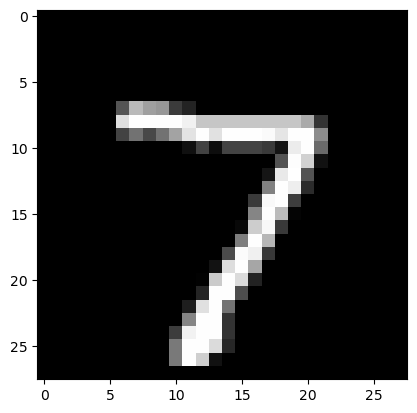

In [20]:
# Original image
imshow(torchvision.utils.make_grid(images[0]))

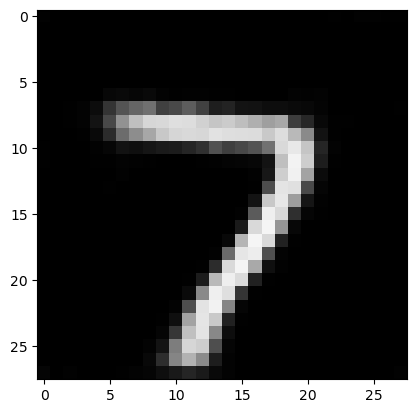

In [21]:
# Reproduced image
imshow(torchvision.utils.make_grid(out.cpu()[0]))